In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

In [ ]:
import os, re, string
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
import sklearn

from simpletransformers.classification import ClassificationModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.simplefilter('ignore')

pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 2000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_type = 'roberta'
model_name = 'roberta-large'
weight = [0.43, 0.57]
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 4,
               'gradient_accumulation_steps': 2,
               'do_lower_case': True,
               'learning_rate': 1e-05,
               'best_model_dir': '/content/drive/My Drive/Datos/nlp-with-simple-transformer/outputs/best_model',
               'cache_dir': '/content/drive/My Drive/Datos/nlp-with-simple-transformer/cache_dir',
               'output_dir': '/content/drive/My Drive/Datos/nlp-with-simple-transformer/outputs/',
               'tensorboard_dir': '/content/drive/My Drive/Datos/nlp-with-simple-transformer/runs/',
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 2}

In [ ]:
# Original dataset of the competition
train_data = pd.read_csv('/content/drive/My Drive/Datos/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Datos/test.csv')
sample_submission = pd.read_csv("/content/drive/My Drive/Datos/sample_submission.csv")

In [ ]:
# Calculo el largo de cada tweet y su diferencia con el promedio
train_data = train_data[["text", "target"]]
train_data["len"] = train_data["text"].str.len()
mean = round(train_data["len"].mean())
train_data["diff_mean"] = train_data["len"] - mean
train_data.head()

,text,target,len,diff_mean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,-32
1,Forest fire near La Ronge Sask. Canada,1,38,-63
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,32
3,"13,000 people receive #wildfires evacuation orders in California",1,65,-36
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,-13


In [ ]:
# Como simpletransformer toma solo una columna para entrenar,
# concatenamos al principio de text el largo y la diferencia
train_data["text"] = train_data["len"].astype(str) + ";" + train_data["diff_mean"].astype(str) + ";" + train_data["text"]
train_data.head()

,text,target,len,diff_mean
0,69;-32;Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,-32
1,38;-63;Forest fire near La Ronge Sask. Canada,1,38,-63
2,133;32;All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,32
3,"65;-36;13,000 people receive #wildfires evacuation orders in California",1,65,-36
4,88;-13;Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,-13


In [ ]:
# Realizamos lo mismo para el set de test
test_data = test_data[["text"]]
test_data["len"] = test_data["text"].str.len()
test_data["mean_diff"] = test_data["len"] - mean
test_data.head()

,text,len,mean_diff
0,Just happened a terrible car crash,34,-67
1,"Heard about #earthquake is different cities, stay safe everyone.",64,-37
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,-5
3,Apocalypse lighting. #Spokane #wildfires,40,-61
4,Typhoon Soudelor kills 28 in China and Taiwan,45,-56


In [ ]:
test_data["text"] = test_data["len"].astype(str) + ";" + test_data["mean_diff"].astype(str) + ";" + test_data["text"]
test_data.head()

,text,len,mean_diff
0,34;-67;Just happened a terrible car crash,34,-67
1,"64;-37;Heard about #earthquake is different cities, stay safe everyone.",64,-37
2,"96;-5;there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,-5
3,40;-61;Apocalypse lighting. #Spokane #wildfires,40,-61
4,45;-56;Typhoon Soudelor kills 28 in China and Taiwan,45,-56


In [ ]:
model = ClassificationModel(model_type, model_name, use_cuda = True, args=model_args, weight=weight) 
model.train_model(train_data)
result, model_outputs, wrong_predictions = model.eval_model(train_data, acc=sklearn.metrics.accuracy_score)
y_preds, _, = model.predict(test_data['text'])
pred_train, _ = model.predict(train_data['text'])

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.o

In [ ]:
acc = result['acc']
result

In [ ]:
# Predicciones para Kaggle
sample_submission["target"] = y_preds
sample_submission.to_csv("/content/drive/My Drive/Datos/nlp-with-simple-transformer/submission5.csv", index=False)
y_preds[:20]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

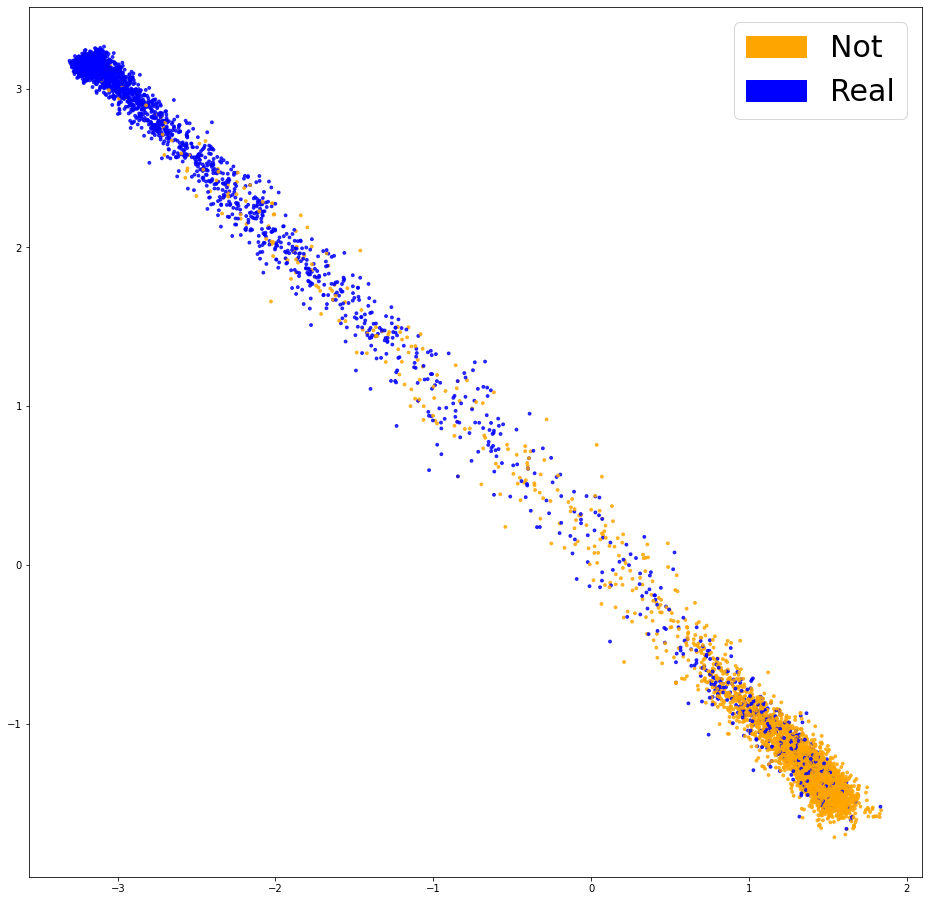

In [ ]:
# Visualización de la predicción sobre el modelo de entrenamiento
def plot_data_lavel(data, labels):
    colors = ['orange','blue']
    plt.scatter(data[:,0], data[:,1], s=8, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    orange_patch = mpatches.Patch(color='orange', label='Not')
    blue_patch = mpatches.Patch(color='blue', label='Real')
    plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_data_lavel(model_outputs, train_data['target'].values)
plt.show()